







### import pandas as pd
import csv
import ssl

accident_all = pd.read_csv("./csvs/data.csv", encoding='cp949')
accident_all.tail()

In [10]:
accident_all.isna().sum() # 결측치체크

id       0
사고지      0
문화센터     0
실외체육     0
옐로카펫     0
놀이터      0
교회       0
초등학교     0
유치원      0
학원       0
버스정류장    0
pc방      0
dtype: int64

In [11]:
accident_place = accident_all['id']
accident_all = accident_all.drop('id', axis=1)

x = accident_all.drop('사고지', axis=1)
y = accident_all['사고지']

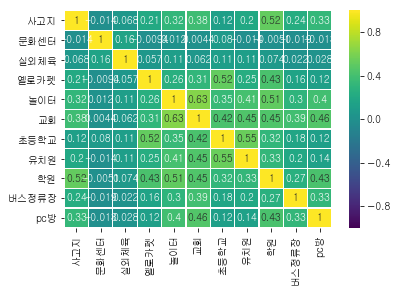

In [13]:
# 상관관계
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc # 한글폰트깨짐 방지


# 한국어 폰트 깨짐 방지 코드----------------
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
#-------------------------------------------

sns.heatmap(accident_all.corr(), vmax = 1, vmin = -1, annot = True,
           linewidths = 0.2, cmap = 'viridis')
plt.show()

In [14]:
# 다중공선성: 독립변수 간 상관관계가 있는 것, 부정확한 회귀결과 도출 가능
# VIF: 상관관계가 있는지 없는지 확인하는 척도, 10 미만일 시 정상적인 학습 가능

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler1.fit(x)
X = scaler1.transform(x)

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X, i) for i in range(len(X[0]))]
vif['features'] = accident_all.drop('사고지', axis = 1).columns # 사고지를 제외한 변수들 간 다중공선성 구하기
# 사고지 제외 이유: 사고지를 대상으로 타 변수들과의 회귀분석을 통해 사고지를 예측하는 것이 최종 목표이므로
vif

,VIF Factor,features
0,1.043239,문화센터
1,1.050167,실외체육
2,1.573878,옐로카펫
3,1.918034,놀이터
4,2.143557,교회
5,1.914194,초등학교
6,1.650006,유치원
7,1.731224,학원
8,1.230796,버스정류장
9,1.472792,pc방


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 5) # random seed
fold1 = StratifiedKFold(n_splits = 5) # 5 fold

In [16]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action='ignore') 


# KNN==========================================================================
params = {
    'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
model1 = KNeighborsClassifier()
grid1 = GridSearchCV(model1, param_grid=params, scoring='accuracy', cv=fold1)
grid1.fit(X_train, y_train)
print(f'KNN 최적의 하이퍼 파라미터 : {grid1.best_params_}')
print(f'KNN 최적의 모델 평균 성능 : {grid1.best_score_}')


# LogisticRegression============================================================
params = {
    'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}
model2 = LogisticRegression()
grid2 = GridSearchCV(model2, param_grid=params, scoring='accuracy', cv=fold1)
grid2.fit(X_train, y_train)
print(f'LogisticRegression 최적의 하이퍼 파라미터 : {grid2.best_params_}')
print(f'LogisticRegression 최적의 모델 평균 성능 : {grid2.best_score_}')



# SVM===========================================================================
params = {
    'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}
model3 = svm.SVC()
grid3 = GridSearchCV(model3, param_grid=params, scoring='accuracy', cv=fold1)
grid3.fit(X_train, y_train)
print(f'SVM 최적의 하이퍼 파라미터 : {grid3.best_params_}')
print(f'SVM 최적의 모델 평균 성능 : {grid3.best_score_}')


# 결정트리======================================================================
params = {
    # 질문 깊이
    'max_depth' : [1, 2, 3, 4, 5]
}
model4 = DecisionTreeClassifier()
grid4 = GridSearchCV(model4, param_grid=params, scoring='accuracy', cv=fold1)
grid4.fit(X_train, y_train)
print(f'결정트리 최적의 하이퍼 파라미터 : {grid4.best_params_}')
print(f'결정트리 최적의 모델 평균 성능 : {grid4.best_score_}')



# 랜덤 포레스트=================================================================
params = {
    #트리의 개수
    'n_estimators': [i for i in range(20, 202, 50)],
    # 질문 깊이
    'max_depth' : [ 1, 2, 3, 4, 5]
}
model5 = RandomForestClassifier()
grid5 = GridSearchCV(model5, param_grid=params, scoring='accuracy', cv=fold1)
grid5.fit(X_train, y_train)
print(f'랜덤포레스트 최적의 하이퍼 파라미터 : {grid5.best_params_}')
print(f'랜덤포레스트 최적의 모델 평균 성능 : {grid5.best_score_}')



# 부스팅========================================================================

params = {
    #트리의 개수
    'n_estimators': [i for i in range(20, 202, 50)],
    # 질문 깊이
    'max_depth' : [1, 2, 3, 4, 5]
}
model6 = GradientBoostingClassifier()
grid6 = GridSearchCV(model6, param_grid=params, scoring='accuracy', cv=fold1)
grid6.fit(X_train, y_train)
print(f'부스팅 최적의 하이퍼 파라미터 : {grid6.best_params_}')
print(f'부스팅 최적의 모델 평균 성능 : {grid6.best_score_}')


# XG부스팅======================================================================
params = {
    #트리의 개수
    'n_estimators': [i for i in range(20, 202, 50)],
    # 질문 깊이
    'max_depth' : [1, 2, 3, 4, 5]
}
model7 = XGBClassifier(silent = True, verbosity = 0)
grid7 = GridSearchCV(model7, param_grid=params, scoring='accuracy', cv=fold1)
grid7.fit(X_train, y_train)
print(f'XG부스팅 최적의 하이퍼 파라미터 : {grid7.best_params_}')
print(f'XG부스팅 최적의 모델 평균 성능 : {grid7.best_score_}')




C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


KNN 최적의 하이퍼 파라미터 : {'n_neighbors': 4}
KNN 최적의 모델 평균 성능 : 0.9383333333333334
LogisticRegression 최적의 하이퍼 파라미터 : {'C': 100}
LogisticRegression 최적의 모델 평균 성능 : 0.9383333333333334
SVM 최적의 하이퍼 파라미터 : {'C': 0.0001}
SVM 최적의 모델 평균 성능 : 0.9333333333333333
결정트리 최적의 하이퍼 파라미터 : {'max_depth': 1}
결정트리 최적의 모델 평균 성능 : 0.9333333333333333
랜덤포레스트 최적의 하이퍼 파라미터 : {'max_depth': 4, 'n_estimators': 70}
랜덤포레스트 최적의 모델 평균 성능 : 0.9383333333333334
부스팅 최적의 하이퍼 파라미터 : {'max_depth': 1, 'n_estimators': 120}
부스팅 최적의 모델 평균 성능 : 0.9433333333333334
XG부스팅 최적의 하이퍼 파라미터 : {'max_depth': 2, 'n_estimators': 20}
XG부스팅 최적의 모델 평균 성능 : 0.94


In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# 7개 모델 중 최적의 모델을 선정함
votingC = VotingClassifier(estimators=[('knn', grid1), ('Logi', grid2), ('svm', grid3),
                                     ('DT', grid4), ('RF', grid5), ('Boost', grid6), ('XGB', grid7)], voting = 'hard')
votingC = votingC.fit(X_train, y_train)

pred = votingC.predict(X_test)
print("Voting 분류기 정확도: {0: .4f}".format(accuracy_score(y_test, pred)))

classifiers = [grid1, grid2, grid3, grid4, grid5, grid6, grid7]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.best_estimator_
    print('{0} 정확도: {1: .4f}'.format(class_name, accuracy_score(y_test,pred)))

Voting 분류기 정확도:  0.8992
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform') 정확도:  0.8837
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 정확도:  0.8876
SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 정확도:  0.9031
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

In [18]:
# id, 사고지를 제외한 데이터 불러오기 -> 학습을 위함
accident_all_new_model = pd.read_csv('./csvs/model_data.csv', encoding = 'cp949')
accident_all_new_model.head()

,문화센터,실외체육,옐로카펫,놀이터,교회,초등학교,유치원,학원,버스정류장,pc방
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [19]:
# voting 결과를 활용하기 위해 데이터 불러오기
accident_all_new_voting = pd.read_csv('./csvs/data.csv', encoding = 'cp949')
accident_all_new_voting.head()

,id,사고지,문화센터,실외체육,옐로카펫,놀이터,교회,초등학교,유치원,학원,버스정류장,pc방
0,790,0,0,0,0,0,0,0,0,0,0,0
1,791,0,0,0,0,0,0,0,0,0,0,0
2,788,0,0,0,0,0,0,0,0,0,0,0
3,789,0,0,0,0,0,0,0,0,0,0,0
4,786,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# voting 모델에 학습 데이터 삽입
voting_pred = votingC.predict(accident_all_new_model)
voting_proba_df = accident_all_new_model

# target 변수: 사고지역 예측
voting_proba_df['target'] = voting_pred
# id 와의 매핑 -> 이후 qgis 사용
voting_proba_df['id'] = accident_place
print(voting_proba_df)

# voting 모델 학습 완료 csv 저장
voting_proba_df.to_csv("./csvs/target.csv", encoding = 'cp949')

     문화센터  실외체육  옐로카펫  놀이터  교회  초등학교  유치원  학원  버스정류장  pc방  target   id
0       0     0     0    0   0     0    0   0      0    0       0  790
1       0     0     0    0   0     0    0   0      0    0       0  791
2       0     0     0    0   0     0    0   0      0    0       0  788
3       0     0     0    0   0     0    0   0      0    0       0  789
4       0     0     0    0   0     0    0   0      0    0       0  786
5       0     0     0    0   0     0    0   0      0    0       0  787
6       0     0     0    0   0     0    0   0      1    0       0  784
7       0     0     0    0   0     0    0   0      0    0       0  785
8       0     0     0    0   0     0    0   0      0    0       0  798
9       0     0     0    1   0     0    0   1      3    0       0  799
10      0     0     0    0   0     0    0   0      0    0       0  796
11      0     0     0    0   0     0    0   0      0    0       0  797
12      0     0     0    0   0     0    0   0      0    0       0  794
13    

In [21]:
# target 값이 1보다 큰 id들만 모아보기
voting_proba_df1 = voting_proba_df[voting_proba_df['target']>=1]
voting_proba_df1

,문화센터,실외체육,옐로카펫,놀이터,교회,초등학교,유치원,학원,버스정류장,pc방,target,id
31,0,0,1,4,6,2,1,7,4,6,1,762
48,0,1,0,1,7,0,0,1,1,4,1,725
54,0,0,0,1,4,0,1,1,3,4,1,728
107,0,0,0,1,8,0,1,3,5,5,1,645
157,0,0,0,1,4,0,2,2,3,2,1,607
185,0,1,2,7,3,2,2,32,1,2,2,561
246,0,0,1,5,6,2,2,3,1,1,1,522
284,0,0,0,7,5,0,2,7,4,2,1,490
357,0,0,0,5,5,0,2,15,2,3,1,404
363,0,0,1,5,7,2,2,17,2,0,2,403


In [18]:
voting_proba_df1.to_csv("보팅모델사고지.csv", encoding = 'cp949')